# WNTR Pipe Break Demo
This demonstration covers how to run simple pipe break analysis using WNTR.

### 1 Simulation set up

#### 1a Import packages
Numpy and Matplotlib are required to support data handling and graphics/plotting.

In [1]:
import wntr
import matplotlib.pyplot as plt
import numpy as np

# Set colormap for network maps
cmap=plt.cm.get_cmap('viridis')

#### 1b Create a water network model
If adapting code for a different INP file, code for 1b and 1c need to be changed to reflect the correct file path and desired simulation parameters.

In [2]:
# Identify file path to inp file
inp_file = '../networks/Net3.inp'

# Create water network model 
wn = wntr.network.WaterNetworkModel(inp_file)

#### 1c Define pipe break parameters
The parameters `minimum_pressure` and `required_pressure` are used for PDD simulations. Nodes with pressures below minimum pressure will not receive any water, and node pressures need to be at least the required pressure to receive all of the requested demand.

The parameter `min_pipe_diam` defines the lower limit of pipe diameters to include in analysis.  

In [3]:
# Define simulation parameters 
start_time = 2*3600 # 2 hours
break_duration = 12*3600 # 12 hours
total_duration = start_time + break_duration # 14 hours

minimum_pressure = 3.52 # 5 psi
required_pressure = 14.06 # 20 psi 

min_pipe_diam = 0.3048 # 12 inch

### 2 Check normal conditions

#### 2a Identify non-zero (NZD) junctions that fall below minimum pressure during normal conditions
This step helps determine which junctions that experience low pressures during the disaster simulation are a direct result of the disaster (step 4). 

In [4]:
# Calculate average expected demand and identify junctions with non-zero average expected demand (AED)
AED = wntr.metrics.average_expected_demand(wn)
nzd_junct = AED[AED > 0].index

# Set hydraulic parameters
wn.options.hydraulic.demand_model = 'PDD'    
wn.options.time.duration = total_duration
wn.options.hydraulic.minimum_pressure = minimum_pressure
wn.options.hydraulic.required_pressure = required_pressure 

# Run simulation
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

# Save junction pressure results and identify junctions that fall below minimum pressure
pressure = results.node['pressure'].loc[start_time::, nzd_junct]
normal_pressure_below_pmin = pressure.columns[(pressure < minimum_pressure).any()]

### 3 Query pipes to include in analysis

In [5]:
# Queries all pipes with diameter greater than threshold set in 1c
pipes_of_interest = wn.query_link_attribute('diameter', np.greater_equal, min_pipe_diam)

### 4 Simulate hydraulics

A try/except/finally approach is taken to ensure the script can finish running and still catch any convergence issues that might have occurred due to a pipe break. A user can revisit nodes with failed simulations individually to determine the cause of failure, if desired. 

In [6]:
# Create dictionary to save results
analysis_results = {} 

# Simulate pipe break (simulated as pipe closures) for each pipe
for pipe_name in pipes_of_interest.index: 
    wn = wntr.network.WaterNetworkModel(inp_file)
    wn.options.hydraulic.demand_model = 'PDD'    
    wn.options.time.duration = total_duration
    wn.options.hydraulic.minimum_pressure = minimum_pressure
    wn.options.hydraulic.required_pressure = required_pressure
    
    # Create pipe closure control and apply to pipe of interest
    pipe = wn.get_link(pipe_name)
    act = wntr.network.controls.ControlAction(pipe, 'status', 0)
    cond = wntr.network.controls.SimTimeCondition(wn, 'Above', start_time)
    ctrl = wntr.network.controls.Control(cond, act)
    wn.add_control('close pipe ' + pipe_name, ctrl)
    
    try:
        # Simulate hydraulics
        sim = wntr.sim.WNTRSimulator(wn) 
        sim_results = sim.run_sim()
 
        # Using pressure results, identify impacted junctions
        sim_pressure = sim_results.node['pressure'].loc[start_time::, nzd_junct]
        sim_pressure_below_pmin = sim_pressure.columns[(sim_pressure < minimum_pressure).any()]
        impacted_junctions = set(sim_pressure_below_pmin) - set(normal_pressure_below_pmin)
        
    except Exception as e:
        # Identify failed simulations and the reason
        impacted_junctions = None
        print(pipe_name, ' Failed:', e)

    finally:
        # Save simulation results
        analysis_results[pipe_name] = impacted_junctions

### 5 Visualize results

#### 5a Calculate junction and population impacts

In [7]:
# Calculate population per junction
population = wntr.metrics.population(wn)

# Save junction and population impact results to dictionary
num_junctions_impacted = {}
num_people_impacted = {}
for pipe_name, impacted_junctions in analysis_results.items():
    if impacted_junctions is not None:
        num_junctions_impacted[pipe_name] = len(impacted_junctions)
        num_people_impacted[pipe_name] = population[impacted_junctions].sum()

#### 5b Plot results
If a different INP file from the example Net3.inp file is being used, the parameter `node_range` can be adjusted to better suit the simulation results.

<AxesSubplot:title={'center':'Number of people impacted by each pipe closure'}>

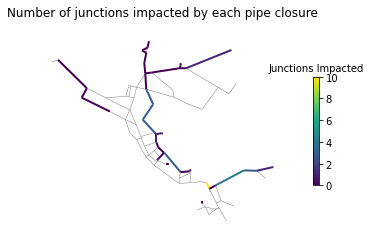

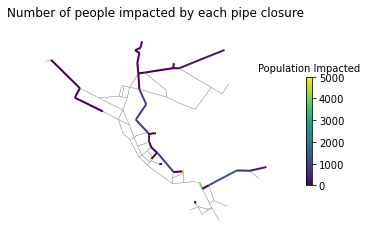

In [8]:
#Plot junctions impacted due to pipe breaks
wntr.graphics.plot_network(wn, link_attribute=num_junctions_impacted, node_size=0, link_width=2, 
                           link_range=[0,10], link_cmap = cmap, link_colorbar_label='Junctions Impacted', 
                           title='Number of junctions impacted by each pipe closure')

#Plot population impacted due to pipe breaks
wntr.graphics.plot_network(wn, link_attribute=num_people_impacted, node_size=0, link_width=2, 
                           link_range=[0,5000], link_cmap = cmap, link_colorbar_label='Population Impacted',
                           title='Number of people impacted by each pipe closure')

#### Data Testing
The following code is included for data testing and is not required for pipe break analysis.

In [9]:
import pandas as pd

# Test simulation results
# Import expected results
junct_test = pd.read_csv('../../wntr/tests/data_for_testing/pipe_break_demo_junction_test_data.csv', index_col=0, squeeze=True).to_dict()
junct_test = {str(key): value for key, value in junct_test.items()}

people_test = pd.read_csv('../../wntr/tests/data_for_testing/pipe_break_demo_people_test_data.csv', index_col=0, squeeze=True).to_dict()
people_test = {str(key): value for key, value in people_test.items()}

# Check if simulation results match expected results
assert num_junctions_impacted == junct_test, "impacted junction results differ"
assert num_people_impacted == people_test, "impacted people results differ"